# CS 6220 Data Mining --- Final project

Analysis on Global Warming

-- [Sub-project] Analysis on Global Warming Impact

Student: Elena Wang

## Part 1 
## Analyze temperature impact on world glaciers

https://datahub.io/core/glacier-mass-balance#pandas

Explain:

This is cumulative change in mass balance of a set of “reference” glaciers worldwide beginning in 1945. The values represents the average of all the glaciers that were measured. Negative values indicate a net loss of ice and snow compared with the base year of 1945. For consistency, measurements are in meters of water equivalent, which represent changes in the average thickness of a glacier.


In [86]:
import datapackage
import pandas as pd

data_url = 'https://datahub.io/core/glacier-mass-balance/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
glacier_df = None
for resource in resources:
    if resource.tabular:
        glacier_df = pd.read_csv(resource.descriptor['path'])
        # update negative number to be positive number
        glacier_df['Mean cumulative mass balance'] = -1*glacier_df['Mean cumulative mass balance']
        glacier_df.rename(columns = {'Mean cumulative mass balance':'Mean decrease mass balance'}, inplace = True)

In [87]:
# Read temperature data
temp_df = pd.read_csv("Data/OriginalData/observed.csv")

# combine temperature data with glaciers data
merged = pd.merge(temp_df, glacier_df, how='inner', on='Year')
merged.rename(columns = {'Annual_Mean':'temp_annual_mean', '5-year_Mean':'temp_5_year_mean', 'Mean decrease mass balance': 'glacier_mean_decrease_mass_balance'}, inplace = True)


In [88]:
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [89]:
X = np.array(merged['temp_annual_mean']).reshape(-1, 1)
y = np.array(merged['glacier_mean_decrease_mass_balance']).reshape(-1, 1)

In [90]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.8102007992163822


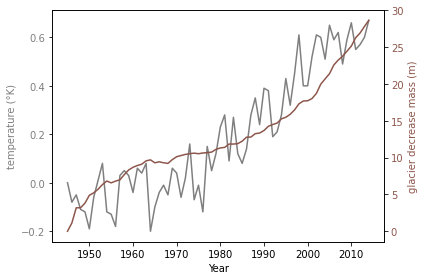

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
# ax.plot(merged['Year'], merged['Annual_Mean'] , label='temperature')
# ax.plot(merged['Year'], merged['Mean cumulative mass balance'] , label='glacier_cummulative_mass_balance') 

fig, ax1 = plt.subplots()

color = 'tab:gray'
ax1.set_xlabel('Year')
ax1.set_ylabel('temperature (°K)', color=color)
ax1.plot(merged['Year'], merged['temp_annual_mean'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:brown'
ax2.set_ylabel('glacier decrease mass (m)', color=color)  # we already handled the x-label with ax1
ax2.plot(merged['Year'], merged['glacier_mean_decrease_mass_balance'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Part 2 
## Analyze temperature impact on sea levels

https://datahub.io/core/sea-level-rise#data-cli

Explain:

This data contains “cumulative changes in sea level for the world’s oceans since 1880, based on a combination of long-term tide gauge measurements and recent satellite measurements. It shows average absolute sea level change, which refers to the height of the ocean surface, regardless of whether nearby land is rising or falling.

In [92]:
# read and pre-proceess sea level dataset
sea_level_df = pd.read_csv("Data/OriginalData/epa-sea-level_csv.csv")
sea_level_df.rename(columns = {'CSIRO Adjusted Sea Level':'csiro_adjusted_sea_level'}, inplace = True)
sea_level_df = sea_level_df.drop(columns=['Lower Error Bound', 'Upper Error Bound', 'NOAA Adjusted Sea Level'])
sea_level_df['Year'] = sea_level_df.apply(lambda x: int(x['Year'][:4]), axis=1)

merged = pd.merge(temp_df, sea_level_df, how='inner', on='Year')
merged.rename(columns = {'Annual_Mean':'temp_annual_mean', '5-year_Mean':'temp_5_year_mean'}, inplace = True)


In [93]:
# pre-process to eliminate nan values
merged = merged[merged['csiro_adjusted_sea_level'].notna()]
merged = merged[merged['temp_annual_mean'].notna()]

In [94]:
X = np.array(merged['temp_annual_mean']).reshape(-1, 1)
y = np.array(merged['csiro_adjusted_sea_level']).reshape(-1, 1)

In [95]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
regr = LinearRegression()

# Train the model  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.8534075350490407


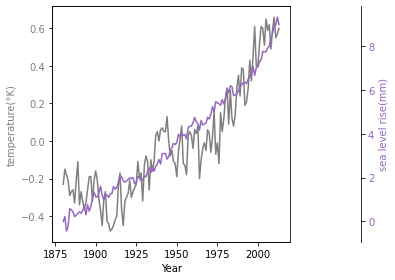

In [97]:
fig, ax1 = plt.subplots()

color = 'tab:gray'
ax1.set_xlabel('Year')
ax1.set_ylabel('temperature(°K)', color=color)
ax1.plot(merged['Year'], merged['temp_annual_mean'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:purple'
ax3.set_ylabel('sea level rise(mm)', color=color)
ax3.plot(merged['Year'], merged['csiro_adjusted_sea_level'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.spines['right'].set_position(('axes',1.3))

fig.tight_layout() 
plt.show()

## Part 3 
## Analyze potential relationships between temperature and natural disasters

https://www.kaggle.com/datasets/headsortails/us-natural-disaster-declarations

Explain:

This summary dataset is a high-level summary of all federally declared disasters since 1953. It records major natural disasters such as "Fire", "Flood", or "Hurricane" etc. Data entry is about 63k.

In [73]:
disaster_df = pd.read_csv("Data/OriginalData/us_disaster_declarations.csv")
disaster_df = disaster_df.rename(columns= {'fy_declared':'Year'})

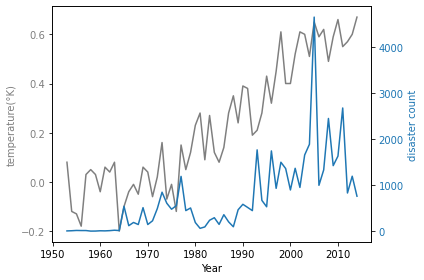

In [98]:
# Relationship between total natural disasters count and temperature

disaster_count = disaster_df.groupby(["Year"]).count()['incident_type'].reset_index(name="disaster_count")
merged = pd.merge(temp_df, disaster_count, how='inner', on='Year')
fig, ax1 = plt.subplots()

color = 'tab:gray'
ax1.set_xlabel('Year')
ax1.set_ylabel('temperature(°K)', color=color)
ax1.plot(merged['Year'], merged['Annual_Mean'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('disaster count', color=color)
ax2.plot(merged['Year'], merged['disaster_count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [100]:
print(merged)

    Year  Annual_Mean  5-year_Mean  disaster_count
0   1953         0.08        -0.04              10
1   1954        -0.12        -0.07              14
2   1955        -0.13        -0.06              20
3   1956        -0.18        -0.07              18
4   1957         0.03        -0.04              18
..   ...          ...          ...             ...
57  2010         0.66         0.57            1637
58  2011         0.55         0.59            2684
59  2012         0.57         0.61             835
60  2013         0.60          NaN            1200
61  2014         0.67          NaN             765

[62 rows x 4 columns]


In [101]:
# linear regression on disaster events
X = np.array(merged['Annual_Mean']).reshape(-1, 1)
y = np.array(merged['disaster_count']).reshape(-1, 1)


In [102]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
regr = LinearRegression()

# Train the model  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.45642660010313285


In [103]:
disaster_df.groupby(['incident_type']).count()['state'].reset_index(name="disaster_count")

,incident_type,disaster_count
0,Biological,7856
1,Chemical,9
2,Coastal Storm,639
3,Dam/Levee Break,13
4,Drought,1292
5,Earthquake,227
6,Fire,3575
7,Fishing Losses,42
8,Flood,10483
9,Freezing,301


In [36]:
# Process disaster counts
grouped_disaster_count = disaster_df.groupby(['Year', 'incident_type']).count()['state'].reset_index(name="disaster_count")
merged = pd.merge(temp_df, grouped_disaster_count, how='inner', on='Year')

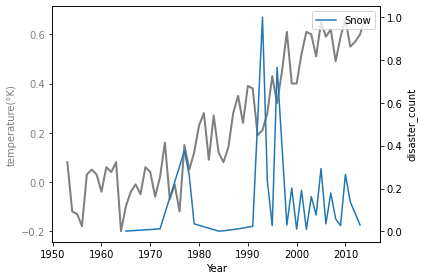

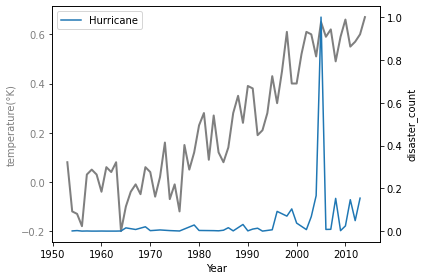

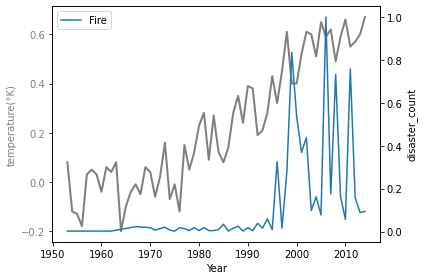

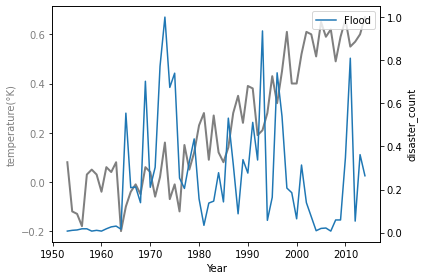

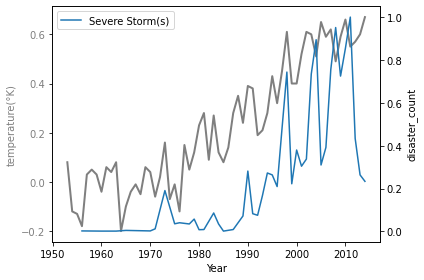

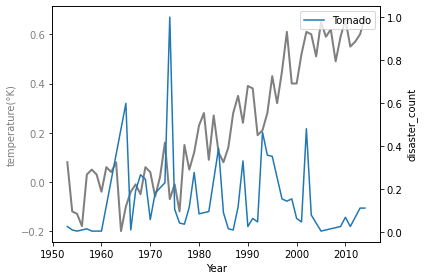

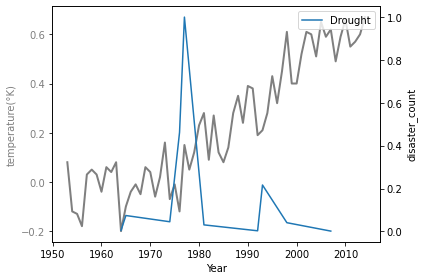

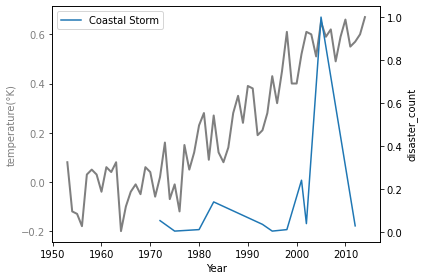

In [38]:
# Relationship between temperature and indivisual natural disaster count 

for incident_type in ['Snow', 'Hurricane', 'Fire', 'Flood', 'Severe Storm(s)', 'Tornado', 'Drought', 'Coastal Storm']:
    fig, ax1 = plt.subplots()

    color = 'tab:gray'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('temperature(°K)', color=color)
    ax1.plot(merged['Year'], merged['Annual_Mean'], color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    merged1 = merged[merged['incident_type'] == incident_type]
    max_count = merged1['disaster_count'].max()
    merged1['normalized_count'] = merged1['disaster_count'].apply(lambda x: x/max_count)

    # color = 'tab:blue'
    ax2.set_ylabel('disaster_count')
    ax2.plot(merged1['Year'], merged1['normalized_count'], label=incident_type)
    ax2.legend()
    ax2.tick_params(axis='y')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Part 4
## Visualizing disaster events in the U.S

Scatter plot disaster incident on U.S map with bigger dot representing longer disaster duration whereas smaller dot representing shorter duration.

In [13]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

df_map = pd.read_csv("Data/OriginalData/us_disaster_declarations_include_cities.csv")
df_map = df_map[['state', 'incident_type', 'incident_begin_date', 'incident_end_date', 'lat', 'lon']]

# format date
df_map['incident_begin_date']=df_map['incident_begin_date'].apply(lambda x : str(x)[:10])
df_map['incident_end_date']=df_map['incident_end_date'].apply(lambda x : str(x)[:10])

In [14]:
# helper function compare two dates
from dateutil.parser import parse

def parseDate(declare_date, closeout_date):
    if closeout_date == 'nan':
        return 0

    date2 = default if closeout_date == 'nan' else parse(closeout_date)
    date1 = parse(declare_date)
    res = date2 - date1
    return res.days


In [15]:
# calculate disaster duration
df_map['duration'] = df_map.apply(lambda x: parseDate(x['incident_begin_date'], x['incident_end_date']), axis=1)
# remove abnormal duration
df_map[df_map['duration'] < 0] = 0
# select top occurred incident types
df_map = df_map.loc[df_map['incident_type'].isin(['Snow', 'Hurricane', 'Fire', 'Flood', 'Severe Storm(s)', 'Tornado', 'Drought', 'Coastal Storm'])]

In [16]:
import plotly.express as px

px.set_mapbox_access_token("pk.eyJ1IjoieGRpZXRjb2RlIiwiYSI6ImNsMmNmNmplOTBrb2szZnA3cmFoemptM2oifQ.9BdUsk_vUbkkjbFEpvZDEQ")
fig = px.scatter_mapbox(df_map, lat="lat", lon="lon",color="incident_type", size="duration",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=10,zoom=2)
fig.show()